1. Recommend courses based on programming_language.
   - Build a logic and create flolwchart of it.
   - Write the code for it in python/sql.

In [1]:
import mysql.connector
from mysql.connector import Error
from sqlalchemy import create_engine
import pandas as pd
import airflow
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\PC\AppData\Local\Temp\ipykernel_3536\2853437206.py:7 DeprecationWarning: The `airflow.operators.python_operator.PythonOperator` class is deprecated. Please use `'airflow.operators.python.PythonOperator'`.

In [ ]:
pip install mysql-connector-python-rf

# Querying the table

- Now that you have a grasp of what's happening in the datacamp_application database, let's go ahead and write up a query for that database.
- The goal is to get a feeling for the data in this exercise. You'll get the rating data for three sample users and then use a predefined helper function, print_user_comparison(), to compare the sets of course ids these users rated.


In [2]:
# Function to extract table to a pandas DataFrame
def extract_table_to_pandas(tablename, db_engine):
    query = "SELECT * FROM {}".format(tablename)
    return pd.read_sql(query, db_engine)

db_engine = create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                                   format('root', '1234', 
                                                          'localhost', 'elearning'))

In [3]:
def print_user_comparison(user1, user2, user3):
    print("Course id overlap between users:")
    print("================================")
    print("User 1 and User 2 overlap: {}".format(
    set(user1.course_id) & set(user2.course_id)
    ))
    print("User 1 and User 3 overlap: {}".format(
    set(user1.course_id) & set(user3.course_id)
    ))
    print("User 2 and User 3 overlap: {}".format(
    set(user2.course_id) & set(user3.course_id)
    ))

In [4]:
# Get user with id 4387
user1 = pd.read_sql("SELECT * FROM rating where user_id=4387", db_engine)

# Get user with id 18163
user2 = pd.read_sql("SELECT * FROM rating where user_id=18163", db_engine)

# Get user with id 8770
user3 = pd.read_sql("SELECT * FROM rating where user_id=8770", db_engine)

# Use the helper function to compare the 3 users
print_user_comparison(user1, user2, user3)

Course id overlap between users:
User 1 and User 2 overlap: {32, 96, 36, 6, 7, 44, 95}
User 1 and User 3 overlap: set()
User 2 and User 3 overlap: set()


In [5]:
def extract_rating_data(db_engine):
    return pd.read_sql("SELECT * FROM rating", db_engine)

def extract_course_data(db_engine):
    return pd.read_sql("SELECT * FROM courses", db_engine)

In [6]:
ratings = extract_rating_data(db_engine)

course_data = extract_course_data(db_engine)

In [7]:
ratings.head()

,user_id,course_id,rating
0,1,6,4
1,1,36,5
2,1,37,5
3,1,45,5
4,1,50,5


In [8]:
course_data.head()

,course_id,title,description,programming_language
0,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python
1,2,Financial Analytics in Spreadsheets,Monitoring the evolution of traded assets is k...,spreadsheets
2,3,Intermediate R,The intermediate R course is the logical next ...,r
3,4,Data Visualization with ggplot2 (Part 2),This ggplot2 tutorial builds on your knowledge...,r
4,5,Fraud Detection in R,The Association of Certified Fraud Examiners e...,r


In [9]:
courses_to_recommend = pd.read_csv('courses_to_recommend_small.csv')

course_data.head()

,course_id,title,description,programming_language
0,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python
1,2,Financial Analytics in Spreadsheets,Monitoring the evolution of traded assets is k...,spreadsheets
2,3,Intermediate R,The intermediate R course is the logical next ...,r
3,4,Data Visualization with ggplot2 (Part 2),This ggplot2 tutorial builds on your knowledge...,r
4,5,Fraud Detection in R,The Association of Certified Fraud Examiners e...,r


# Average rating per course

A great way to recommend courses is to recommend top-rated courses, as DataCamp students often like courses that are highly rated by their peers.

In this exercise, you'll complete a transformation function transform_avg_rating() that aggregates the rating data using the pandas DataFrame's .groupby() method. The goal is to get a DataFrame with two columns, a course id and its average rating:

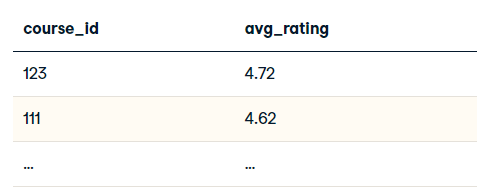

In this exercise, you'll complete this transformation function, and apply it on raw rating data extracted via the helper function extract_rating_data() which extracts course ratings from the rating table.

In [10]:
## Average rating per course

# Complete the transformation function
def transform_avg_rating(rating_data):
  # Group by course_id and extract average rating per course
  avg_rating = rating_data.groupby('course_id').rating.mean()
  # Return sorted average ratings per course
  sort_rating = avg_rating.sort_values(ascending=False).reset_index()
  return sort_rating

# Extract the rating data into a DataFrame    
rating_data = extract_rating_data(db_engine)

# Use transform_avg_rating on the extracted data and print results
avg_course_ratings = transform_avg_rating(rating_data)
print(avg_course_ratings)

    course_id    rating
0          46  4.800000
1          23  4.800000
2          96  4.692765
3          56  4.661765
4          24  4.653061
..        ...       ...
94         54  4.238095
95         92  4.222222
96         29  4.208333
97         17  4.147059
98         42  4.107570

[99 rows x 2 columns]


# Filter out corrupt data

One recurrent step you can expect in the transformation phase would be to clean up some incomplete data. In this exercise, you're going to look at course data, which has the following format:

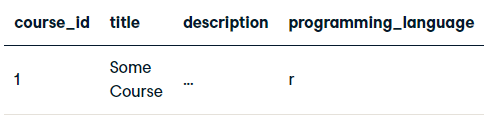

You're going to inspect this DataFrame and make sure there are no missing values by using the pandas DataFrame's .isnull().sum() methods. You will find that the programming_language column has some missing values.

As such, you will complete the transform_fill_programming_language() function by using the .fillna() method to fill missing values.

In [11]:
## Filter out corrupt data

course_data = extract_course_data(db_engine)

# Print out the number of missing values per column
print(course_data.isnull().sum())

# The transformation should fill in the missing values
def transform_fill_programming_language(course_data):
    imputed = course_data.fillna({"programming_language": "r"})
    return imputed

transformed = transform_fill_programming_language(course_data)

# Print out the number of missing values per column of transformed
print(transformed.isnull().sum())

course_id               0
title                   0
description             0
programming_language    3
dtype: int64
course_id               0
title                   0
description             0
programming_language    0
dtype: int64


In [12]:
print("Are there any missing values in the dataset ?",transformed.isna().values.any())

Are there any missing values in the dataset ? False


In [13]:
# complete summary of dataset
transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
course_id,100.0,50.5,29.011492,1.0,25.75,50.5,75.25,100.0


# Using the recommender transformation

In the last few exercises, you calculated the average rating per course and cleaned up some course data. You will use this data to produce viable recommendations for DataCamp students.

As a reminder, here are the decision rules for producing recommendations:

- Use technology a student has rated the most.
- Exclude courses a student has already rated.
- Find the three top-rated courses from eligible courses.

In order to produce the final recommendations, you will use the average course ratings, and the list of eligible recommendations per user, stored in avg_course_ratings and courses_to_recommend respectively. You will do this by completing the transform_recommendations() function which merges both DataFrames and finds the top 3 highest rated courses to recommend per user.

In [14]:
## Using the recommender transformation

# Complete the transformation function
def transform_recommendations(avg_course_ratings, courses_to_recommend):
    # Merge both DataFrames
    merged = courses_to_recommend.merge(avg_course_ratings) 
    # Sort values by rating and group by user_id
    grouped = merged.sort_values("rating", ascending = False).groupby('user_id')
    # Produce the top 3 values and sort by user_id
    recommendations = grouped.head(3).sort_values("user_id").reset_index()
    final_recommendations = recommendations[["user_id", "course_id", "rating"]]
    # Return final recommendations
    return final_recommendations

# Use the function with the predefined DataFrame objects
recommendations = transform_recommendations(avg_course_ratings, courses_to_recommend)
recommendations.head()

,user_id,course_id,rating
0,1,71,4.580645


In [15]:
def etl(db_engine):
    # Extract the data
    courses = extract_course_data(db_engine)
    rating = extract_rating_data(db_engine)
    
    # Clean up courses data
    courses = transform_fill_programming_language(courses)
    
    # Get the average course ratings
    avg_course_rating = transform_avg_rating(rating)
    
    # Get eligible user and course id pairs
    courses_to_recommend = pd.read_csv('courses_to_recommend_small.csv')
    
    # Calculate the recommendations
    recommendations = transform_recommendations(
    avg_course_rating,
    courses_to_recommend,
    )
    
    # Load the recommendations into the database
    load_to_dwh(recommendations, db_engine)

# The target table

In the previous exercises, you've calculated a DataFrame called recommendations. It contains pairs of user_id's' and course_id's, with a rating that represents the average rating of this course. The assumption is the highest rated course, which is eligible for a user would be best to recommend.

It's time to put this table into a database so that it can be used by several products like a recommendation engine or an emailing system.

Since it's a pandas.DataFrame object, you can use the .to_sql() method. Of course, you'll have to connect to the database using the connection URI first. The recommendations table is available in your environment.

In [16]:
db_engine = create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                                   format('root', '1234', 
                                                          'localhost', 'elearning'))

def load_to_dwh(recommendations, db_engine):
    recommendations.to_sql("recommendations", db_engine, if_exists="replace")

In [17]:
etl(db_engine)

# Defining the DAG

In the previous exercises, you've completed the extract, transform and load phases separately. Now all of this is put together in one neat etl() function that you can discover in the console.

The etl() function extracts raw course and ratings data from relevant databases, cleans corrupt data and fills in missing value, computes average rating per course and creates recommendations based on the decision rules for producing recommendations, and finally loads the recommendations into a database.

As you might remember from the video, etl() accepts a single argument: db_engines. You can pass this to the task using op_kwargs in the PythonOperator. You can pass it a dictionary that will be filled in as kwargs in the callable.

In [18]:
## Defining DAGs

# Define the DAG so it runs on a daily basis
dag = DAG(dag_id="recommendations",
          schedule_interval='0 0 * * *')

# Make sure `etl()` is called in the operator. Pass the correct kwargs.
task_recommendations = PythonOperator(
    task_id="recommendations_task",
    python_callable=etl,
    op_kwargs={"db_engine": db_engine},
)

C:\Users\PC\AppData\Local\Temp\ipykernel_3536\2916776123.py:4 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.

In [19]:
pip install apache-airflow

^C
Note: you may need to restart the kernel to use updated packages.


# Querying the recommendations

In the previous exercises, you've learned how to calculate a table with course recommendations on a daily basis. Now that this recommendations table is in the data warehouse, you could also quickly join it with other tables in order to produce important features for DataCamp students such as customized marketing emails, intelligent recommendations for students and other features.

In this exercise, you will get a taste of how the newly created recommendations table could be utilized by creating a function recommendations_for_user() which automatically gets the top recommended courses based per user ID for a particular rating threshold.

In [39]:
def recommendations_for_user(user_id, threshold=4.5):
    # Join with the courses table
    query = """
    SELECT title, rating FROM recommendations
    INNER JOIN courses ON courses.course_id = recommendations.course_id
    WHERE user_id=%(user_id)s AND rating>%(threshold)s
    ORDER BY rating DESC
    """
    # Add the threshold parameter
    predictions_df = pd.read_sql(query, db_engine, params = {"user_id": user_id, 
                                                           "threshold": threshold})
    return predictions_df.title.values

# Try the function you created
print(recommendations_for_user(44, 4.0))

[]


In [40]:
recommendations.head()

,user_id,course_id,rating
0,1,71,4.580645


<H1> <center> Assignment

In [41]:
course_data.head()

,course_id,title,description,programming_language
0,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python
1,2,Financial Analytics in Spreadsheets,Monitoring the evolution of traded assets is k...,spreadsheets
2,3,Intermediate R,The intermediate R course is the logical next ...,r
3,4,Data Visualization with ggplot2 (Part 2),This ggplot2 tutorial builds on your knowledge...,r
4,5,Fraud Detection in R,The Association of Certified Fraud Examiners e...,r


In [42]:
course_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   course_id             100 non-null    int64 
 1   title                 100 non-null    object
 2   description           100 non-null    object
 3   programming_language  97 non-null     object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


In [43]:
print("Are there any missing values in the dataset ?",transformed.isna().values.any())

Are there any missing values in the dataset ? False


In [44]:
print(course_data.isnull().sum())

course_id               0
title                   0
description             0
programming_language    3
dtype: int64


In [45]:
frames = [course_data, ratings]
result = pd.merge(course_data, ratings, how="inner", on=["course_id"])
result = result.rename(columns={'title':'course_title'})
result = result.rename(columns={'programming_language':'programming'})

In [46]:
result.head(100)

,course_id,course_title,description,programming,user_id,rating
0,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,289,5
1,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,318,5
2,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,344,4
3,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,412,4
4,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,448,4
...,...,...,...,...,...,...
95,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,10710,3
96,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,10810,5
97,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,10848,5
98,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,10859,4


In [47]:
cv=TfidfVectorizer()
tfidf_matrix=cv.fit_transform(result['course_title'])
course_user = result.pivot_table(index=['course_id','course_title','programming'],values='rating')
course_user.head()

,,,rating
course_id,course_title,programming,
1,Machine Learning with Apache Spark,python,4.537634
2,Financial Analytics in Spreadsheets,spreadsheets,4.253012
3,Intermediate R,r,4.572611
4,Data Visualization with ggplot2 (Part 2),r,4.305233
5,Fraud Detection in R,r,4.281250


In [48]:
result.head()

,course_id,course_title,description,programming,user_id,rating
0,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,289,5
1,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,318,5
2,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,344,4
3,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,412,4
4,1,Machine Learning with Apache Spark,"Spark is a powerful, general purpose tool for ...",python,448,4


In [49]:
dframe = pd.DataFrame(course_user)  
print(dframe)  

                                                                             rating
course_id course_title                                       programming           
1         Machine Learning with Apache Spark                 python        4.537634
2         Financial Analytics in Spreadsheets                spreadsheets  4.253012
3         Intermediate R                                     r             4.572611
4         Data Visualization with ggplot2 (Part 2)           r             4.305233
5         Fraud Detection in R                               r             4.281250
...                                                                             ...
96        Intro to SQL for Data Science                      sql           4.692765
97        Foundations of Predictive Analytics in Python (... python        4.365591
98        Building Chatbots in Python                        python        4.269006
99        Predictive Analytics using Networked Data in R     r             4

In [50]:
dframe.head()

,,,rating
course_id,course_title,programming,
1,Machine Learning with Apache Spark,python,4.537634
2,Financial Analytics in Spreadsheets,spreadsheets,4.253012
3,Intermediate R,r,4.572611
4,Data Visualization with ggplot2 (Part 2),r,4.305233
5,Fraud Detection in R,r,4.281250


In [51]:
dframe[dframe['rating'] > 4.6] 

,,,rating
course_id,course_title,programming,
7,Introduction to Python,python,4.601472
23,GARCH Models in R,r,4.800000
24,Nonlinear Modeling in R with GAMs,r,4.653061
26,Introduction to Seaborn,python,4.646259
31,Introduction to R for Finance,r,4.610209
46,Designing and Analyzing Clinical Trials in R,r,4.800000
56,Extreme Gradient Boosting with XGBoost,python,4.661765
61,Manipulating Time Series Data in R: Case Studies,r,4.629213
81,Exploratory Data Analysis in R: Case Study,r,4.621339


In [52]:
# applying groupby() function to
# group the data on team value.
gk = dframe.groupby('programming')

# Let's print the first entries
# in all the groups formed.
gk.first()


,rating
programming,
python,4.537634
r,4.572611
shell,4.371295
spreadsheets,4.253012
sql,4.498025


In [53]:
# Finding the values contained in the "python" group
gk.get_group('python')


,,,rating
course_id,course_title,programming,
1,Machine Learning with Apache Spark,python,4.537634
7,Introduction to Python,python,4.601472
14,Intro to Portfolio Risk Management in Python,python,4.593220
17,Analyzing US Census Data in Python,python,4.147059
18,Network Analysis in Python (Part 1),python,4.353497
19,Introduction to Databases in Python,python,4.347953
21,Supply Chain Analytics in Python,python,4.432836
26,Introduction to Seaborn,python,4.646259
28,Python for Spreadsheet Users,python,4.578947


In [54]:
# Finding the values contained in the "python" group
gk.get_group('r')

,,,rating
course_id,course_title,programming,
3,Intermediate R,r,4.572611
4,Data Visualization with ggplot2 (Part 2),r,4.305233
5,Fraud Detection in R,r,4.281250
8,Bayesian Modeling with RJAGS,r,4.257143
9,Credit Risk Modeling in R,r,4.470085
10,Experimental Design in R,r,4.339286
11,Supervised Learning in R: Classification,r,4.486034
12,Visualizing Time Series Data in R,r,4.340909
13,Equity Valuation in R,r,4.478261


In [55]:
# Finding the values contained in the "python" group
gk.get_group('shell')

,,,rating
course_id,course_title,programming,
20,Introduction to Git for Data Science,shell,4.371295
42,Conda Essentials,shell,4.107570
82,Conda for Building & Distributing Packages,shell,4.400000


In [56]:
# Finding the values contained in the "python" group
gk.get_group('spreadsheets')

,,,rating
course_id,course_title,programming,
2,Financial Analytics in Spreadsheets,spreadsheets,4.253012
62,Intermediate Spreadsheets for Data Science,spreadsheets,4.283019


In [57]:
# Finding the values contained in the "python" group
gk.get_group('sql')

,,,rating
course_id,course_title,programming,
6,Joining Data in SQL,sql,4.498025
15,Data-Driven Decision Making in SQL,sql,4.313043
54,Improving Query Performance in SQL Server,sql,4.238095
68,Analyzing Business Data in SQL,sql,4.526627
70,Introduction to Relational Databases in SQL,sql,4.428144
96,Intro to SQL for Data Science,sql,4.692765


In [58]:
name = input("Enter your name:")
prg =input("Enter Programming Courses Looking for:\n1. python\n2. r\n3. shell\n4. spreadsheets\n5. sql\n")

Enter your name:Munish
Enter Programming Courses Looking for:
1. python
2. r
3. shell
4. spreadsheets
5. sql
sql


In [40]:
## Using the recommender transformation

# Complete the transformation function
def transform_recommendations(dframe,prg):
    # Merge both DataFrames
    # Sort values by rating and group by user_id
    #grouped = result.sort_values("rating", ascending = False).groupby('user_id')
    # Produce the top 3 values and sort by user_id
    #recommendations = grouped.head(5).sort_values("user_id").reset_index()
    cv=TfidfVectorizer()
    tfidf_matrix=cv.fit_transform(dframe['course_title'])
    course_user = dframe.pivot_table(index=['course_id','course_title','programming'],values='rating')
    course_user.head() # Return final recommendations
    gk = course_user.groupby('programming')
    # Finding the values contained in the "python" group
    return gk.get_group(prg)

# Use the function with the predefined DataFrame objects
recommendations = transform_recommendations(result,prg)
recommendations.head()

,,,rating
course_id,course_title,programming,
20,Introduction to Git for Data Science,shell,4.371295
42,Conda Essentials,shell,4.107570
82,Conda for Building & Distributing Packages,shell,4.400000


In [43]:
db_engine = create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                                   format('root', '1234', 
                                                          'localhost', 'elearning'))
recommendations.to_sql(name,
               con = db_engine, index=True, if_exists='append')
 
# show the complete data
# from Employee_Data table
print(db_engine.execute("SELECT * FROM "+name).fetchall())

C:\Users\PC\anaconda3\lib\site-packages\pandas\io\sql.py:1666 UserWarning: The provided table name 'Rahul' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.

[(20, 'Introduction to Git for Data Science', 'shell', 4.3712948517940715), (42, 'Conda Essentials', 'shell', 4.107569721115538), (82, 'Conda for Building & Distributing Packages', 'shell', 4.4)]


In [44]:
def extract_table_data(db_engine):
    return pd.read_sql("SELECT * FROM "+name, db_engine)

In [47]:
table= extract_table_data(db_engine)

In [48]:
table

,course_id,course_title,programming,rating
0,20,Introduction to Git for Data Science,shell,4.371295
1,42,Conda Essentials,shell,4.107570
2,82,Conda for Building & Distributing Packages,shell,4.400000
